In [1]:
import pennylane as qml
from pennylane import numpy as np
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

<h1>
    VQC from Pennylane Tutorial
</h1>

In [2]:
np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [3]:
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

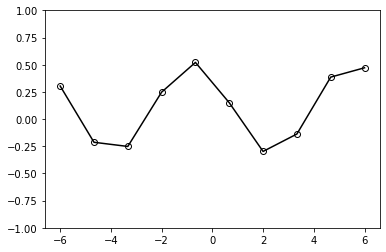

In [4]:
# x = np.linspace(-6, 6, 70, requires_grad=False)
x = np.linspace(-6, 6, 10, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show();

In [5]:
scaling = 1
dev = qml.device('default.qubit', wires=1)

def S(x):
    """Data-encoding circuit block."""
    qml.RX(scaling * x, wires=0)

def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

@qml.qnode(dev, interface="autograd")
def serial_quantum_model(weights, x):

    for theta in weights[:-1]:
        W(theta)
        S(x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))


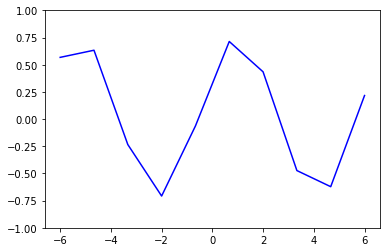

In [6]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights

# x = np.linspace(-6, 6, 70, requires_grad=False)
x = np.linspace(-6, 6, 10, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [7]:
print(qml.draw(serial_quantum_model)(weights, x[-1]))

0: ──Rot(2.35,5.97,4.60)──RX(6.00)──Rot(3.76,0.98,0.98)─┤  <Z>


In [8]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.04399170920148863
Cost at step  20: 0.014850992412216426
Cost at step  30: 0.006944251473307758
Cost at step  40: 0.004579625718577732
Cost at step  50: 0.001000598291589949


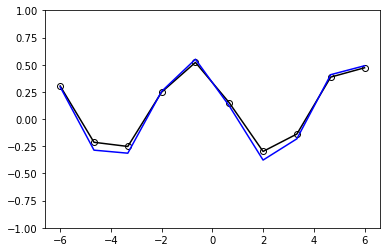

In [9]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

<img src="pics/RFF1-steps.png" width="480" height="240"/>


In [10]:
# Step 1: Diagonalize the encoding gates and find eiganvalues
# Compute the matrix representation of the circuit
unitary_matrix = qml.matrix(serial_quantum_model)(weights, x)

# Compute the eigenvalues of the unitary matrix
eigenvalues = np.linalg.eigvals(unitary_matrix)
# print(unitary_matrix)
print(eigenvalues)

[[ 0.29947682+0.95410358j  0.29947682-0.95410358j]
 [ 0.51811695+0.85530978j  0.51811695-0.85530978j]
 [ 0.5148862 -0.85725854j  0.5148862 +0.85725854j]
 [ 0.29116806-0.95667192j  0.29116806+0.95667192j]
 [-0.05723566-0.9983607j  -0.05723566+0.9983607j ]
 [-0.38112961-0.92452162j -0.38112961+0.92452162j]
 [-0.54181416-0.84049832j -0.54181416+0.84049832j]
 [-0.47048008+0.88241062j -0.47048008-0.88241062j]
 [-0.19767444+0.98026773j -0.19767444-0.98026773j]
 [ 0.15978043+0.98715258j  0.15978043-0.98715258j]]


In [11]:
# theta = 6.0
# rx_matrix = np.matrix([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2), np.cos(theta/2)]])
# print(rx_matrix)

# np.linalg.eig(rx_matrix)

In [12]:
# Step 2: Use all eigenvalues to obtain the frequencies

<img src="pics/eq4.png" width="480" height="240"/>
<img src="pics/eq5.png" width="480" height="240"/>

In [13]:
def get_uppercase_lambda(eiganvalues, idx):
    uppercase_lambda = 0
    for i in range(len(eiganvalues)):
        uppercase_lambda += eiganvalues[i] ** idx
    return uppercase_lambda

def get_omega(eiganvalues): 
    lambdas = []
    for i in range(len(eiganvalues)):
        lth_ev = eiganvalues[i]
        ith_uppercase_lambda = get_uppercase_lambda(lth_ev, i + 1)
        lambdas.append(ith_uppercase_lambda)
    
    # TODO: Do subtraction between all pairs in lambdas
    

<h1>
    VQC from Lecture Demo
</h1>

In [14]:
n_samples = 100

X, y = make_blobs(
    n_samples=n_samples, 
    centers=[[0.1, 0.2], [0.25, 0.4]], 
    cluster_std=0.05, 
    n_features=2,
    random_state=6
)

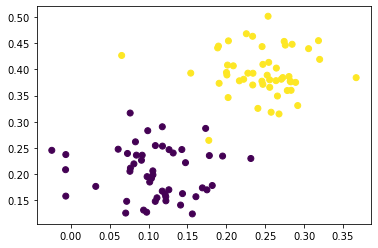

In [15]:
plot_data(X, y)

In [16]:
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)
y[y == 0] = -1

In [17]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def model_2(point, weights):
    qml.AngleEmbedding(point, wires=[0, 1])
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliX(0))

In [18]:
weights = np.random.normal(size=(2, 3), requires_grad=True)
weights

tensor([[-1.04591267, -1.78055668,  0.76798327],
        [ 1.60123823, -0.79695144, -0.07577083]], requires_grad=True)

In [19]:
print(qml.draw(model_2, expansion_strategy="device")(X[0], weights))

0: ──RX(0.12)──Rot(-1.05,-1.78,0.77)─╭X─┤  <X>
1: ──RX(0.25)──Rot(1.60,-0.80,-0.08)─╰●─┤     


In [20]:
loss = make_loss_function(X, y, model_2)

In [21]:
# opt = qml.GradientDescentOptimizer(stepsize=0.1)

# n_its = 100

# loss_track = []

# for it in range(n_its):
#     weights, _loss = opt.step_and_cost(loss, weights)
#     if it % 5 == 0:
#         our_preds = make_predictions(X, model_2, weights)
#         print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
#     loss_track.append(_loss)

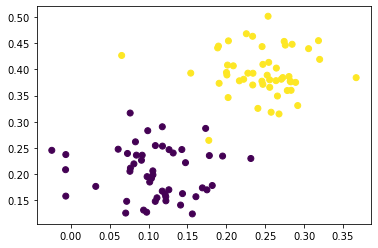

In [22]:
our_preds = make_predictions(X, model_2, weights)
plot_data(X, y)

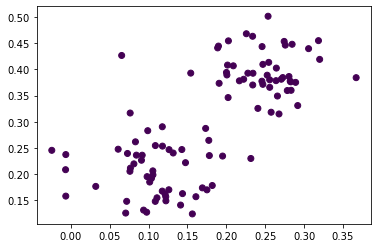

In [23]:
plot_data(X, our_preds)

In [24]:
compute_accuracy(our_preds, y)

0.5

<h1>
    Steps
</h1>

<img src="pics/RFF1-steps.png" width="480" height="240"/>


In [25]:
# print(weights)
# coeffs = weights

In [26]:
# 1. Diagonalize the Hamiltonians of the above VQC

obs = [qml.PauliX(0)]
coeffs = [1]
H = qml.Hamiltonian(coeffs, obs)

print(H)

  (1) [X0]


In [27]:
w, v = np.linalg.eig(H)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional